To do list and doubts:

- usar label encoder ou onehotencoder? ou uma mistura dos dois
- matriz de correlação, apesar dos valores estarem grandes em algumas colunas, não acredito que a gente deve tirar algo por conta disso.
- usei muitos fills para consertar as colunas mistas (existem colunas mistas no sentido de que são mistura entre int, float e str (usualmente são valores 'normal' escrito))
    - substitui os valores que são 'normal' para valores medianos para dar fill e ficar a coluna somente com um tipo de variável
- as colunas que são relacionadas a 'preço' são normalmente erradas em termos naturais, "listing.pricingInfo.yearlyIptu", "listing.pricingInfo.rentalPrice", "listing.pricingInfo.monthlyCondoFee". Uma normalização apenas resolveria isso? Talvez sim, mas fico em duvida sobre a realidade dos valores, pois por exemplo listing.pricingInfo.monthlyCondoFee varia entre 1.0 a 990.0, mas faz sentido ser esses valores?
- testar tecnicas de normalização (normalização ou padronização dos dados depois de transformar as colunas categoricas em numericas)
- imvl_type vs. listing.unitTypes
- drop duplicates

Este é um trabalho em grupo de no máximo 5 participantes. Cada participante deverá enviar o trabalho completo individualmente pelo Classroom.

Descrição do trabalho de desenvolvimento das tarefas de regressão e classificação sobre dados de imóveis coletados a partir da web:

Este trabalho tem como objetivo desenvolver tarefas de regressão e classificação sobre dados de imóveis coletados a partir da web por meio do uso de webscraping. Os alunos podem utilizar este coletor de dados, disponível em https://github.com/serpaandre/ScrapZAP/blob/master/scrap_zap_v2.py como base para coleta de novos dados do site ZAP.

Utilizaremos os dados disponíveis no repositório https://www.kaggle.com/datasets/maverickjpa/brazilian-real-estate-to-rent e também vamos incrementar esse dataset com novos dados coletados por meio de webscraping. 

A tarefa de regressão consiste em prever o valor de venda de um imóvel. Para isso, utilizaremos os modelos de knn, regressão linear e regressão logística, além de outros modelos que não foram apresentados em sala de aula. A avaliação dos modelos será feita com base no cálculo do erro médio quadrático (MSE) e do coeficiente de determinação (R²), que são medidas comuns para avaliar a precisão de modelos de regressão.

Para a tarefa de classificação, criaremos um novo atributo que mapeia os valores de venda de imóveis em três padrões: BAIXO, MÉDIO e ALTO. Utilizaremos modelos de arvore de decisão para a tarefa de classificação, bem como outros modelos que não foram apresentados em sala de aula. A avaliação dos modelos será feita com base na acurácia e na matriz de confusão.
O prazo para a entrega do trabalho é de 3 semanas. Durante esse período, os alunos devem coletar novos dados de imóveis por meio de webscraping, a fim de incrementar o dataset disponível. É importante lembrar que os dados devem ser pré-processados, tratados e normalizados antes de serem utilizados nos modelos de regressão e classificação.

Espera-se que os alunos desenvolvam habilidades de programação em Python e familiaridade com técnicas de regressão e classificação. O trabalho é uma oportunidade para aplicar conceitos e teorias estudados em sala de aula em um problema real, além de fomentar a criatividade e a inovação na solução de problemas. O sucesso do trabalho dependerá do empenho e dedicação dos alunos em cada etapa do processo.

Adição: Cada equipe deve fazer um vídeo de até 15 minutos, com TODOS da equipe, explicando o notebook que foi feito (gravando apenas a tela). E enviar junto do notebook aqui pelo google classroom.

A nota para este trabalho será contabilizada da seguinte forma:

(4,0) Coleta e tratamento dos dados, incluindo webscraping
(4,0) Treinamento dos modelos RL, RLog, KNN, Arvore
(2,0) Avaliação dos resultados e ajustes

(1,0) BONUS - novos modelos treinados e avaliados

In [1]:
import pandas as pd
import numpy as np
import nb_black
import os
import warnings
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    log_loss,
)

from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
    Ridge,
    Lasso,
    ElasticNet,
)
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor

warnings.filterwarnings("ignore")

%load_ext lab_black

## Métodos

Essa secao ficara todos os metodos e funçoes que serao utilizadas no projeto, a fim de deixar mais organizado e limpo para facilitar o entendimento

In [2]:
def print_shape_dfs(folder_path):
    files = os.listdir(folder_path)
    csv_files = [f for f in files if f.endswith(".csv")]

    for file in csv_files:
        filepath = os.path.join(folder_path, file)
        df = pd.read_csv(filepath, delimiter=";")
        print(f"{file} -> {df.shape}")

In [3]:
def concat_csv_files(folder_path):
    files = os.listdir(folder_path)
    csv_files = [f for f in files if f.endswith(".csv")]
    print_shape_dfs(folder_path)

    dfs = []
    for file in csv_files:
        filepath = os.path.join(folder_path, file)
        temp_df = pd.read_csv(filepath, delimiter=";")
        dfs.append(temp_df)

    df_kaggle = pd.read_csv("dataZAP.csv", delimiter=";")
    dfs.append(df_kaggle)

    all_columns = set().union(*[set(df.columns) for df in dfs])
    dfs = [df.reindex(columns=all_columns) for df in dfs]

    result = pd.concat(dfs, ignore_index=True)
    output_file = os.path.join("./", "dataZap_concatenated.csv")
    result.to_csv(output_file, sep=";", index=False)
    print(f"Shape do df inicial: {df_kaggle.shape}\nShape do df final: {result.shape}")

In [4]:
def check_columns(df):
    check = []
    for column in df.columns:
        types = df[column].apply(type).unique()
        if len(types) > 1:
            if pd.api.types.is_numeric_dtype(df[column]):
                try:
                    converted = pd.to_numeric(df[column], errors="raise")
                except ValueError:
                    check.append(column)
            else:
                check.append(column)

    return check

In [5]:
def remove_outliers(df, num_columns):
    for column in num_columns:
        Q1 = np.percentile(df[column], 25)
        Q3 = np.percentile(df[column], 75)
        IQR = Q3 - Q1

        threshold = 1.5
        lower_limit = Q1 - threshold * IQR
        upper_limit = Q3 + threshold * IQR

        df = df[(df[column] > lower_limit) & (df[column] < upper_limit)]

    return df

In [6]:
def encode_categorical_columns(df, cat_columns):
    encoded_df = df.copy()

    for column in cat_columns:
        encoded_columns = pd.get_dummies(df[column], prefix=column)
        encoded_df = pd.concat([encoded_df, encoded_columns], axis=1)
        encoded_df.drop(column, axis=1, inplace=True)

    return encoded_df

In [424]:
def standardize_columns(df, num_columns):
    standardized_df = df.copy()

    scaler = StandardScaler()
    # scaler = MinMaxScaler()
    standardized_columns = scaler.fit_transform(df[num_columns])
    standardized_df[num_columns] = standardized_columns

    return standardized_df

In [8]:
def evaluate_metrics(actual, pred):
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    rmse = np.sqrt(mean_squared_error(actual, pred))
    R2_score = r2_score(actual, pred)
    print("Model testing performance:")
    print("--------------------------")
    print(f"R2_score \t: {round(R2_score, 4)}")
    print(f"MAE \t\t: {round(mae, 4)}")
    print(f"MSE \t\t: {round(mse, 4)}")
    print(f"RMSE \t\t: {round(rmse, 4)}")

In [9]:
def evaluate_metrics_cv(model, X_train, y_train, X_test, y_test):
    cv_score = cross_val_score(estimator=model, X=X_train, y=y_train, cv=10)

    if isinstance(model, LinearRegression):
        y_pred = model.predict(X_test)

        R2 = model.score(X_test, y_test)
        RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
        MAE = mean_absolute_error(y_test, y_pred)

        CV_RMSE = np.sqrt(
            -cross_val_score(
                estimator=model,
                X=X_train,
                y=y_train,
                cv=10,
                scoring="neg_mean_squared_error",
            ).mean()
        )
        CV_MAE = -cross_val_score(
            estimator=model,
            X=X_train,
            y=y_train,
            cv=10,
            scoring="neg_mean_absolute_error",
        ).mean()

        return ("Linear Regression", R2, cv_score.mean(), RMSE, CV_RMSE, MAE, CV_MAE)

    elif isinstance(model, LogisticRegression):
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        accuracy = model.score(X_test, y_test)
        logloss = log_loss(y_test, y_pred_proba)

        CV_accuracy = cv_score.mean()
        CV_logloss = -cross_val_score(
            estimator=model, X=X_train, y=y_train, cv=10, scoring="neg_log_loss"
        ).mean()

        return ("Logistic Regression", accuracy, CV_accuracy, logloss, CV_logloss)

    elif isinstance(
        model, (Ridge, Lasso, ElasticNet, KNeighborsRegressor, DecisionTreeRegressor)
    ):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        R2 = r2_score(y_test, y_pred)
        RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
        MAE = mean_absolute_error(y_test, y_pred)

        CV_RMSE = np.sqrt(
            -cross_val_score(
                estimator=model,
                X=X_train,
                y=y_train,
                cv=10,
                scoring="neg_mean_squared_error",
            ).mean()
        )
        CV_MAE = -cross_val_score(
            estimator=model,
            X=X_train,
            y=y_train,
            cv=10,
            scoring="neg_mean_absolute_error",
        ).mean()

        return (type(model).__name__, R2, cv_score.mean(), RMSE, CV_RMSE, MAE, CV_MAE)

## Webscraping

### Pre-Incrementação

Essa análise abaixo foi necessária para que nosso script de webscraping tenha as mesmas colunas e formato do dataset que está no kaggle, então abaixo foi feito uma análise sobre o shape deles e também sobre quais colunas tem em um e que não tem no outro, até que se chegou no ponto final, que é quando as duas tem o mesmo shape e colunas iguais, que é o output dessa parte.

Isso impactou no código scrap_zap_v3 (nossa versão), pois tive que modificar as colunas que são filtradas e consequentemente criadas o dataframe.

dfc = dataset do kaggle

dfx = um dos datasets que o webscraping cria

In [553]:
df = pd.read_csv("dataZAP.csv", delimiter=";")
df.shape

(35772, 78)

In [81]:
df_aux = pd.read_csv(
    "webscraping-datasets/dataZap_ce_aluguel_casas_TODOS_3.csv", delimiter=";"
)
df_aux.shape

(352, 78)

In [82]:
dfc = []
for i in df.columns:
    dfc.append(i)

dfx = []
for i in df_aux.columns:
    dfx.append(i)

dfc = set(dfc)
dfx = set(dfx)

In [83]:
len(dfc.intersection(dfx))

78

In [84]:
list(dfc - dfx)

[]

In [85]:
list(dfx - dfc)

[]

Conclusao: Dessa forma final, todas os dataframes que forem realizados pelo webscraping terao as mesmas colunas e quantidades que o dataset do kaggle, facilitando a incrementacao dos dados via scraping.

### Utilização do Script de WebScraping

O site do ZAP tem uma 'proteção' http por scraping, então o excesso de requisições ele acaba bloqueando por alguns minutos para uma outra nova requisição 

In [10]:
!python ./webscraping/scrap_zap_v3.py

TODOS -> TODOS -> rj -> casas -> 4
https://www.zapimoveis.com.br/aluguel/casas/rj/4-quartos/?pagina=52&precoMinimo=100&precoMaximo=2000000


429

Criando o arquivo dataZAP_aluguel_casas_TODOS.csv com os dados

Arquivo criado

Webscraping finalizado!


### Incrementação do Dataset

In [11]:
concat_csv_files("webscraping-datasets")

dataZap_ba_aluguel_casas_TODOS_3.csv -> (495, 78)
dataZap_ce_aluguel_casas_TODOS_3.csv -> (352, 78)
dataZap_es_aluguel_casas_TODOS_3.csv -> (106, 78)
dataZap_mg_aluguel_casas_TODOS_3.csv -> (1727, 78)
dataZap_rj_aluguel_apartamentos_TODOS_1.csv -> (2799, 78)
dataZap_rj_aluguel_apartamentos_TODOS_2.csv -> (8301, 78)
dataZap_rj_aluguel_apartamentos_TODOS_3.csv -> (4126, 78)
dataZap_rj_aluguel_apartamentos_TODOS_4.csv -> (1565, 78)
dataZap_rj_aluguel_apartamentos_TODOS_5.csv -> (107, 78)
dataZap_rj_aluguel_casas_TODOS_1.csv -> (852, 78)
dataZap_rj_aluguel_casas_TODOS_2.csv -> (1610, 78)
dataZap_rj_aluguel_casas_TODOS_3.csv -> (1227, 78)
dataZap_rj_aluguel_casas_TODOS_4.csv -> (1715, 78)
dataZap_rj_aluguel_casas_TODOS_5.csv -> (449, 78)
dataZap_rj_aluguel_cobertura_TODOS_2.csv -> (217, 78)
dataZap_rj_aluguel_cobertura_TODOS_3.csv -> (590, 78)
dataZap_rj_aluguel_cobertura_TODOS_4.csv -> (643, 78)
dataZap_sp_aluguel_casas_TODOS_3.csv -> (8900, 78)
Shape do df inicial: (35772, 78)
Shape do df

## Data Science

### Pre-processamento

In [425]:
df = pd.read_csv("dataZap_concatenated.csv", delimiter=";")

In [426]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71553 entries, 0 to 71552
Data columns (total 78 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   listing.subtitle                      71553 non-null  object
 1   listing.garden                        71553 non-null  bool  
 2   account.licenseNumber                 62336 non-null  object
 3   listing.suites                        66973 non-null  object
 4   listing.bathtub                       71553 non-null  bool  
 5   listing.propertyType                  71553 non-null  object
 6   listing.amenities                     64241 non-null  object
 7   listing.address.level                 71553 non-null  object
 8   listing.listingType                   71553 non-null  object
 9   listing.pricingInfo.businessLabel     71553 non-null  object
 10  listing.pricingInfo.yearlyIptu        60474 non-null  object
 11  listing.pricingInfo.monthlyC

In [427]:
df.describe()

,listing.unitsOnTheFloor,listing.unitFloor,listing.bedrooms,listing.id
count,71553.000000,71553.000000,71553.000000,7.155300e+04
mean,0.318254,0.445069,2.521543,2.515779e+09
std,1.698937,1.982130,1.179905,2.066650e+08
min,0.000000,0.000000,0.000000,4.281836e+07
25%,0.000000,0.000000,2.000000,2.481962e+09
50%,0.000000,0.000000,3.000000,2.490925e+09
75%,0.000000,0.000000,3.000000,2.619714e+09
max,52.000000,102.000000,30.000000,2.634660e+09


In [428]:
df.head()

,listing.subtitle,listing.garden,account.licenseNumber,listing.suites,listing.bathtub,listing.propertyType,listing.amenities,listing.address.level,listing.listingType,listing.pricingInfo.businessLabel,listing.pricingInfo.yearlyIptu,listing.pricingInfo.monthlyCondoFee,listing.pricingInfo.isRent,listing.address.neighborhood,listing.address.street,listing.totalAreas,listing.pricingInfo.rentalPrice,listing.address.point.lon,listing.hottub,listing.updatedAt,listing.sportcourt,listing.address.precision,listing.advertiserId,listing.acceptExchange,listing.isInactive,listing.pricingInfo.rentalTotalPrice,listing.address.confidence,listing.soundproofing,listing.furnished,listing.unitsOnTheFloor,listing.address.point.lat,listing.unitFloor,listing.title,listing.link,listing.bedrooms,listing.unitTypes,account.name,listing.address.zipCode,listing.portal,type,listing.unitSubTypes,listing.businessTypeContext,listing.address.zone,listing.parkingSpaces,listing.preview,listing.description,listing.address.state,listing.address.point.source,listing.bathrooms,listing.pricingInfo.price,listing.pricingInfo.isSale,listing.tenniscourt,listing.legacyId,listing.pricingInfo.period,listing.id,listing.pool,listing.partyhall,listing.createdAt,listing.address.streetNumber,listing.guestpark,listing.barbgrill,listing.publicationType,listing.pricingInfo.salePrice,listing.playground,listing.externalId,listing.pricingInfo.businessType,listing.usableAreas,listing.backyard,listing.displayAddressType,listing.address.country,listing.fireplace,listing.gym,listing.address.city,listing.floors,imvl_type,listing.usageTypes,listing.mountainview,listing.sauna
0,Casa para alugar em,True,NaN,3.0,False,UNIT,DISABLED_ACCESS|BICYCLES_PLACE|PARKING|BARBECU...,CITY,USED,Alugar,NaN,700.0,True,Guarajuba Monte Gordo,Rua Arraia,900.0,3.0,NaN,False,2023-01-12T08:50:05.990Z,True,APPROXIMATE,04c372ee-f00e-7e39-3d53-90cfaa1a8ab2,False,False,NaN,VALID_STREET,False,True,0,NaN,0,Casa para aluguel frente a praia em Guarajuba ...,/imovel/aluguel-casa-3-quartos-mobiliado-guara...,3,HOME,Hansen Imóveis Ltda,42840492.0,GRUPOZAP,superPremium,NaN,RENTAL,Bairros,2.0,False,Sua ampla e super ventilada cozinha americana ...,Bahia,NaN,5,3.000,False,True,NaN,dia,2552533354,False,True,2022-02-22T19:17:45.103Z,NaN,False,True,SUPER_PREMIUM,NaN,False,CO562A,RENTAL,300,False,STREET,BR,False,False,Camaçari,NaN,casas,RESIDENTIAL,False,False
1,Casa para alugar em,False,NaN,1.0,False,UNIT,KITCHEN|INTERCOM|SERVICE_AREA,STREET,USED,Alugar,161.0,NaN,True,Nazaré,NaN,183.0,3.0,NaN,False,2023-05-05T10:02:17.022Z,False,ROOFTOP,01a3699f-cd61-1e5b-591e-a5b91c00fc7e,False,False,NaN,VALID_STREET,False,False,0,NaN,0,"Casa com 3 Dormitórios para Alugar, 183 m² por...",/imovel/aluguel-casa-3-quartos-com-cozinha-naz...,3,HOME,Adriana Silva dos Santos,40050330.0,GRUPOZAP,superPremium,NaN,RENTAL,Bairros,0.0,False,CASA DUPLEX<br><br>PRIMEIRO PAVIMENTO<br><br>0...,Bahia,NaN,3,3.000,False,False,NaN,mês,2628408803,False,False,2023-04-26T00:14:08.546Z,NaN,False,False,SUPER_PREMIUM,NaN,False,CA0218,RENTAL,183,False,NEIGHBORHOOD,BR,False,False,Salvador,NaN,casas,RESIDENTIAL,False,False
2,Casa para alugar e comprar em,False,14268-J-BA,2.0,False,UNIT,NaN,STREET,USED,Alugar/Comprar,260.0,NaN,True,Pituba,Rua Anthenor Tupinambá,1000.0,7.5,-38.451315,False,2023-04-29T21:40:00.231Z,False,GEOMETRIC_CENTER,42074fd8-9c4d-fb59-a874-b1dcb90c6890,False,False,NaN,VALID_STREET,False,False,0,-12.992829,1,Casa Ampla em Pituba - Salvador,/imovel/venda-casa-3-quartos-pituba-salvador-b...,3,HOME,ISLV IMÓVEIS,41810680.0,GRUPOZAP,superPremium,NaN,RENTAL,Bairros,7.0,False,"Casa ampla , situado em uma rua residencial. p...",Bahia,GOOGLE,3,7.500,True,False,NaN,mês,2616700504,False,False,2023-03-04T14:04:38.655Z,NaN,False,False,SUPER_PREMIUM,1.300.000,False,741,RENTAL_SALE,300,False,ALL,BR,False,False,Salvador,NaN,casas,RESIDENTIAL,False,False
3,Casa para alugar em,False,NaN,1.0,False,UNIT,NaN,STREET,USED,Alugar,NaN,NaN,True,Gleba A,Avenida Concêntrica,NaN,1.8,-38

In [429]:
df.isna().sum()

listing.subtitle             0
listing.garden               0
account.licenseNumber     9217
listing.suites            4580
listing.bathtub              0
                         ...  
listing.floors           29866
imvl_type                    0
listing.usageTypes           0
listing.mountainview         0
listing.sauna                0
Length: 78, dtype: int64

#### Analisando as colunas

In [430]:
columns = [
    "listing.pricingInfo.isRent",
    "listing.pricingInfo.isSale",
    "listing.pricingInfo.price",
    "listing.pricingInfo.rentalPrice",
    "listing.pricingInfo.rentalTotalPrice",
    "listing.pricingInfo.salePrice",
]
df[columns]

,listing.pricingInfo.isRent,listing.pricingInfo.isSale,listing.pricingInfo.price,listing.pricingInfo.rentalPrice,listing.pricingInfo.rentalTotalPrice,listing.pricingInfo.salePrice
0,True,False,3.000,3.0,NaN,NaN
1,True,False,3.000,3.0,NaN,NaN
2,True,True,7.500,7.5,NaN,1.300.000
3,True,False,1.800,1.8,NaN,NaN
4,True,False,1.800,1.8,NaN,NaN
...,...,...,...,...,...,...
71548,True,False,1.8,1.8,2.720,normal
71549,True,False,1.19,1.19,1.434,normal
71550,True,False,940.0,940.0,1.054,normal
71551,True,False,1.6,1.6,2.294,normal


In [431]:
df["listing.pricingInfo.rentalTotalPrice"].isna().sum()

17945

In [432]:
df["listing.pricingInfo.price"].isna().sum()

0

In [433]:
df[(df["listing.pricingInfo.isRent"] == True)]

,listing.subtitle,listing.garden,account.licenseNumber,listing.suites,listing.bathtub,listing.propertyType,listing.amenities,listing.address.level,listing.listingType,listing.pricingInfo.businessLabel,listing.pricingInfo.yearlyIptu,listing.pricingInfo.monthlyCondoFee,listing.pricingInfo.isRent,listing.address.neighborhood,listing.address.street,listing.totalAreas,listing.pricingInfo.rentalPrice,listing.address.point.lon,listing.hottub,listing.updatedAt,listing.sportcourt,listing.address.precision,listing.advertiserId,listing.acceptExchange,listing.isInactive,listing.pricingInfo.rentalTotalPrice,listing.address.confidence,listing.soundproofing,listing.furnished,listing.unitsOnTheFloor,listing.address.point.lat,listing.unitFloor,listing.title,listing.link,listing.bedrooms,listing.unitTypes,account.name,listing.address.zipCode,listing.portal,type,listing.unitSubTypes,listing.businessTypeContext,listing.address.zone,listing.parkingSpaces,listing.preview,listing.description,listing.address.state,listing.address.point.source,listing.bathrooms,listing.pricingInfo.price,listing.pricingInfo.isSale,listing.tenniscourt,listing.legacyId,listing.pricingInfo.period,listing.id,listing.pool,listing.partyhall,listing.createdAt,listing.address.streetNumber,listing.guestpark,listing.barbgrill,listing.publicationType,listing.pricingInfo.salePrice,listing.playground,listing.externalId,listing.pricingInfo.businessType,listing.usableAreas,listing.backyard,listing.displayAddressType,listing.address.country,listing.fireplace,listing.gym,listing.address.city,listing.floors,imvl_type,listing.usageTypes,listing.mountainview,listing.sauna
0,Casa para alugar em,True,NaN,3.0,False,UNIT,DISABLED_ACCESS|BICYCLES_PLACE|PARKING|BARBECU...,CITY,USED,Alugar,NaN,700.0,True,Guarajuba Monte Gordo,Rua Arraia,900.0,3.0,NaN,False,2023-01-12T08:50:05.990Z,True,APPROXIMATE,04c372ee-f00e-7e39-3d53-90cfaa1a8ab2,False,False,NaN,VALID_STREET,False,True,0,NaN,0,Casa para aluguel frente a praia em Guarajuba ...,/imovel/aluguel-casa-3-quartos-mobiliado-guara...,3,HOME,Hansen Imóveis Ltda,42840492.0,GRUPOZAP,superPremium,NaN,RENTAL,Bairros,2.0,False,Sua ampla e super ventilada cozinha americana ...,Bahia,NaN,5,3.000,False,True,NaN,dia,2552533354,False,True,2022-02-22T19:17:45.103Z,NaN,False,True,SUPER_PREMIUM,NaN,False,CO562A,RENTAL,300,False,STREET,BR,False,False,Camaçari,NaN,casas,RESIDENTIAL,False,False
1,Casa para alugar em,False,NaN,1.0,False,UNIT,KITCHEN|INTERCOM|SERVICE_AREA,STREET,USED,Alugar,161.0,NaN,True,Nazaré,NaN,183.0,3.0,NaN,False,2023-05-05T10:02:17.022Z,False,ROOFTOP,01a3699f-cd61-1e5b-591e-a5b91c00fc7e,False,False,NaN,VALID_STREET,False,False,0,NaN,0,"Casa com 3 Dormitórios para Alugar, 183 m² por...",/imovel/aluguel-casa-3-quartos-com-cozinha-naz...,3,HOME,Adriana Silva dos Santos,40050330.0,GRUPOZAP,superPremium,NaN,RENTAL,Bairros,0.0,False,CASA DUPLEX<br><br>PRIMEIRO PAVIMENTO<br><br>0...,Bahia,NaN,3,3.000,False,False,NaN,mês,2628408803,False,False,2023-04-26T00:14:08.546Z,NaN,False,False,SUPER_PREMIUM,NaN,False,CA0218,RENTAL,183,False,NEIGHBORHOOD,BR,False,False,Salvador,NaN,casas,RESIDENTIAL,False,False
2,Casa para alugar e comprar em,False,14268-J-BA,2.0,False,UNIT,NaN,STREET,USED,Alugar/Comprar,260.0,NaN,True,Pituba,Rua Anthenor Tupinambá,1000.0,7.5,-38.451315,False,2023-04-29T21:40:00.231Z,False,GEOMETRIC_CENTER,42074fd8-9c4d-fb59-a874-b1dcb90c6890,False,False,NaN,VALID_STREET,False,False,0,-12.992829,1,Casa Ampla em Pituba - Salvador,/imovel/venda-casa-3-quartos-pituba-salvador-b...,3,HOME,ISLV IMÓVEIS,41810680.0,GRUPOZAP,superPremium,NaN,RENTAL,Bairros,7.0,False,"Casa ampla , situado em uma rua residencial. p...",Bahia,GOOGLE,3,7.500,True,False,NaN,mês,2616700504,False,False,2023-03-04T14:04:38.655Z,NaN,False,False,SUPER_PREMIUM,1.300.000,False,741,RENTAL_SALE,300,False,ALL,BR,False,False,Salvador,NaN,casas,RESIDENTIAL,False,False
3,Casa para alugar em,False,NaN,1.0,False,UNIT,NaN,STREET,USED,Alugar,NaN,NaN,True,Gleba A,Avenida Concêntrica,NaN,1.8,-38

In [434]:
df["listing.pricingInfo.businessType"].value_counts()

RENTAL         55205
RENTAL_SALE    14290
SALE_RENTAL     2058
Name: listing.pricingInfo.businessType, dtype: int64

In [435]:
df["listing.displayAddressType"].value_counts()

ALL             38083
STREET          22388
NEIGHBORHOOD    11082
Name: listing.displayAddressType, dtype: int64

In [436]:
df["listing.isInactive"].value_counts()

False    70994
True       559
Name: listing.isInactive, dtype: int64

In [437]:
df["listing.floors"].unique()  # Valores mistos que serão tratados

array([nan, 0.0, 1.0, 3.0, 2.0, 6.0, 12.0, 17.0, 4.0, 10.0, 15.0, 11.0,
       5.0, 8.0, 13.0, 9.0, 16.0, 20.0, 14.0, 7.0, 25.0, 18.0, 26.0, 21.0,
       23.0, 24.0, 22.0, 32.0, 114.0, 19.0, 30.0, 29.0, 28.0, 175.0, 71.0,
       '28.0', '0.0', '3.0', '1.0', '2.0', '6.0', '14.0', '71.0',
       'normal', '2', '21', '10', '13', '15', '12', '4', '20', '6', '8',
       '3', '11', '28', '23', '9', '16', '14', '24', '30', '5', '17',
       '22', '27', '19', '1', '7', '35', '18', '25', '26', '660', '175',
       '31', '32', '33'], dtype=object)

In [438]:
df["listing.totalAreas"].unique()  # Valores mistos que serão tratados

array([900.0, 183.0, 1000.0, ..., '1778', '3600', '1108'], dtype=object)

In [439]:
# Tirando as colunas que nao importam para nossa analise

columns = [
    "listing.address.streetNumber",
    "Page",
    "account.legacyVivarealId",
    "account.legacyZapId",
    "listing.address.geoJson",
    "account.licenseNumber",
    "listing.address.ibgeCityId",
    "listing.id",
    "listing.legacyId",
    "listing.pricingInfo.priceVariation",
    "listing.description",
    "listing.images",
    "listing.videos",
    "listing.pricingInfo.isRent",
    "listing.pricingInfo.isSale",
    "listing.pricingInfo.price",
    "listing.pricingInfo.rentalTotalPrice",
    "listing.pricingInfo.salePrice",
    "listing.unitSubTypes",
    "listing.amenities",
    "account.logoUrl",
    "account.name",
    "link.href",
    "listing.updatedAt",
    "listing.subtitle",
    "listing.title",
    "listing.portal",
    "listing.createdAt",
    "listing.externalId",
    "listing.advertiserId",
    "listing.address.street",
    "listing.address.point.lon",
    "listing.address.point.lat",
    "listing.address.precision",
    "listing.videoTour",
    "listing.address.point.source",
    "listing.address.country",
    "listing.address.confidence",
    "listing.publicationType",
    "listing.pricingInfo.businessType",
    "listing.address.state",
    "listing.listingType",
    "listing.link",
    "listing.propertyType",
    "listing.pricingInfo.businessLabel",
    "listing.isInactive",
    "listing.preview",
    "listing.pricingInfo.period",
    "listing.displayAddressType",
    "listing.acceptExchange",
    "listing.businessTypeContext",
    "listing.usageTypes",
    "listing.address.level",
    "listing.unitTypes",
    "type",
    "listing.address.zipCode",
]

lista_columns = []
for df_columns in df.columns:
    lista_columns.append(df_columns)

for column in columns:
    if column in lista_columns:
        df.drop(columns=column, axis=1, inplace=True)

In [440]:
df.shape

(71553, 33)

#### Limitando a regiao de interesse

Consideramos que a regiao importa para o calculo do modelo de previsao. Entao para isso, iremos fazer um filtro para que a nossa previsao seja mais fidedigna possivel com os valores apresentados. Dessa forma, vamos fazer a analise do preço de aluguel para o estado do Rio de Janeiro

In [441]:
pd.options.display.max_columns = 99
column_filter = df["listing.address.city"] == "Rio de Janeiro"
df = df[column_filter]

In [442]:
df.isna().sum()

listing.garden                             0
listing.suites                          2209
listing.bathtub                            0
listing.pricingInfo.yearlyIptu          5011
listing.pricingInfo.monthlyCondoFee     3096
listing.address.neighborhood               0
listing.totalAreas                      1746
listing.pricingInfo.rentalPrice            0
listing.hottub                             0
listing.sportcourt                         0
listing.soundproofing                      0
listing.furnished                          0
listing.unitsOnTheFloor                    0
listing.unitFloor                          0
listing.bedrooms                           0
listing.address.zone                       0
listing.parkingSpaces                   1732
listing.bathrooms                          0
listing.tenniscourt                        0
listing.pool                               0
listing.partyhall                          0
listing.guestpark                          0
listing.ba

In [443]:
df.drop(columns="listing.address.city", axis=1, inplace=True)

#### Tirando valores repetidos do nosso dataset

In [444]:
print(f"Antes de tirar duplicates: {df.shape}")

Antes de tirar duplicates: (19041, 32)


In [445]:
df.drop_duplicates(inplace=True)

In [446]:
print(f"Depois: {df.shape}")

Depois: (17274, 32)


#### Completando (Fill) os valores nulos

In [447]:
# Como nao pode ter casa sem piso, sera transformado em 1 quando nulo
df["listing.floors"] = df["listing.floors"].fillna(1)

# Valor de iptu nula, deve ser sem iptu
df["listing.pricingInfo.yearlyIptu"] = df["listing.pricingInfo.yearlyIptu"].fillna(0)

# Vaga de estacionamento nula, deve ser sem vagas
df["listing.parkingSpaces"] = df["listing.parkingSpaces"].fillna(0)

# Area total nula, vamos admitir que é o mesmo tamanho da area usavel
df["listing.totalAreas"] = df["listing.totalAreas"].fillna(df["listing.usableAreas"])

In [448]:
df.isna().sum()

listing.garden                            0
listing.suites                         2133
listing.bathtub                           0
listing.pricingInfo.yearlyIptu            0
listing.pricingInfo.monthlyCondoFee    2917
listing.address.neighborhood              0
listing.totalAreas                        0
listing.pricingInfo.rentalPrice           0
listing.hottub                            0
listing.sportcourt                        0
listing.soundproofing                     0
listing.furnished                         0
listing.unitsOnTheFloor                   0
listing.unitFloor                         0
listing.bedrooms                          0
listing.address.zone                      0
listing.parkingSpaces                     0
listing.bathrooms                         0
listing.tenniscourt                       0
listing.pool                              0
listing.partyhall                         0
listing.guestpark                         0
listing.barbgrill               

In [449]:
df[df["listing.suites"].isna() == True][
    ["listing.bathrooms", "listing.bedrooms", "listing.suites"]
]

,listing.bathrooms,listing.bedrooms,listing.suites
2683,2,1,NaN
2684,1,1,NaN
2686,2,1,NaN
2689,1,1,NaN
2691,1,1,NaN
...,...,...,...
26542,7,5,NaN
26607,8,5,NaN
26665,7,5,NaN
26761,4,4,NaN


In [450]:
df[["listing.bathrooms", "listing.bedrooms", "listing.suites"]]

,listing.bathrooms,listing.bedrooms,listing.suites
2680,2,1,1.0
2681,1,1,0.0
2682,1,1,0.0
2683,2,1,NaN
2684,1,1,NaN
...,...,...,...
70569,3,3,1
70617,3,3,1
70883,1,1,0
70920,3,3,1


In [451]:
df = df.dropna(subset=["listing.suites"])

In [452]:
df.isna().sum()

listing.garden                            0
listing.suites                            0
listing.bathtub                           0
listing.pricingInfo.yearlyIptu            0
listing.pricingInfo.monthlyCondoFee    2259
listing.address.neighborhood              0
listing.totalAreas                        0
listing.pricingInfo.rentalPrice           0
listing.hottub                            0
listing.sportcourt                        0
listing.soundproofing                     0
listing.furnished                         0
listing.unitsOnTheFloor                   0
listing.unitFloor                         0
listing.bedrooms                          0
listing.address.zone                      0
listing.parkingSpaces                     0
listing.bathrooms                         0
listing.tenniscourt                       0
listing.pool                              0
listing.partyhall                         0
listing.guestpark                         0
listing.barbgrill               

In [453]:
df["listing.pricingInfo.monthlyCondoFee"].value_counts()

normal    322
300       183
500       144
250       139
350       129
         ... 
1.99        1
1.21        1
612.0       1
961.0       1
3.120       1
Name: listing.pricingInfo.monthlyCondoFee, Length: 3082, dtype: int64

In [454]:
df[df["listing.pricingInfo.monthlyCondoFee"] == "normal"][
    [
        "listing.pricingInfo.monthlyCondoFee",
        "listing.pricingInfo.rentalPrice",
        "listing.bedrooms",
    ]
]

,listing.pricingInfo.monthlyCondoFee,listing.pricingInfo.rentalPrice,listing.bedrooms
35816,normal,3.1,2
35874,normal,4.0,2
35876,normal,3.0,2
36259,normal,1.5,1
36627,normal,250.0,2
...,...,...,...
69502,normal,1.2,2
69861,normal,28.0,6
69863,normal,17.0,4
70375,normal,1.2,2


In [455]:
df["listing.totalAreas"] = pd.to_numeric(df["listing.totalAreas"], errors="coerce")
df["listing.totalAreas"].replace("normal", pd.NA, inplace=True)

df["listing.totalAreas"].fillna(df["listing.totalAreas"].median(), inplace=True)

In [456]:
df["listing.floors"].replace("normal", pd.NA, inplace=True)

df["listing.floors"].fillna(df["listing.floors"].median(), inplace=True)

In [457]:
df["listing.pricingInfo.yearlyIptu"] = pd.to_numeric(
    df["listing.pricingInfo.yearlyIptu"], errors="coerce"
)
df["listing.pricingInfo.yearlyIptu"].replace("normal", pd.NA, inplace=True)

df["listing.pricingInfo.yearlyIptu"].fillna(
    df["listing.pricingInfo.yearlyIptu"].median(), inplace=True
)

In [458]:
df["listing.suites"] = pd.to_numeric(df["listing.suites"], errors="coerce")
df["listing.suites"].replace("normal", pd.NA, inplace=True)

df["listing.suites"].fillna(df["listing.suites"].median(), inplace=True)

In [459]:
df["listing.parkingSpaces"] = pd.to_numeric(
    df["listing.parkingSpaces"], errors="coerce"
)
df["listing.parkingSpaces"].replace("normal", pd.NA, inplace=True)

df["listing.parkingSpaces"].fillna(df["listing.parkingSpaces"].median(), inplace=True)

In [460]:
df["listing.pricingInfo.monthlyCondoFee"].replace("normal", pd.NA, inplace=True)
df["listing.pricingInfo.monthlyCondoFee"] = df[
    "listing.pricingInfo.monthlyCondoFee"
].str.replace(".", "", regex=True)
df["listing.pricingInfo.monthlyCondoFee"] = pd.to_numeric(
    df["listing.pricingInfo.monthlyCondoFee"], errors="coerce"
).astype(float)
df["listing.pricingInfo.monthlyCondoFee"].fillna(
    df["listing.pricingInfo.monthlyCondoFee"].median(), inplace=True
)

In [461]:
df["listing.pricingInfo.rentalPrice"] = pd.to_numeric(
    df["listing.pricingInfo.rentalPrice"], errors="coerce"
)
df["listing.pricingInfo.rentalPrice"].fillna(
    df["listing.pricingInfo.rentalPrice"].median(), inplace=True
)

In [462]:
df.isna().sum()

listing.garden                         0
listing.suites                         0
listing.bathtub                        0
listing.pricingInfo.yearlyIptu         0
listing.pricingInfo.monthlyCondoFee    0
listing.address.neighborhood           0
listing.totalAreas                     0
listing.pricingInfo.rentalPrice        0
listing.hottub                         0
listing.sportcourt                     0
listing.soundproofing                  0
listing.furnished                      0
listing.unitsOnTheFloor                0
listing.unitFloor                      0
listing.bedrooms                       0
listing.address.zone                   0
listing.parkingSpaces                  0
listing.bathrooms                      0
listing.tenniscourt                    0
listing.pool                           0
listing.partyhall                      0
listing.guestpark                      0
listing.barbgrill                      0
listing.playground                     0
listing.usableAr

In [463]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15141 entries, 2680 to 71193
Data columns (total 32 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   listing.garden                       15141 non-null  bool   
 1   listing.suites                       15141 non-null  float64
 2   listing.bathtub                      15141 non-null  bool   
 3   listing.pricingInfo.yearlyIptu       15141 non-null  float64
 4   listing.pricingInfo.monthlyCondoFee  15141 non-null  float64
 5   listing.address.neighborhood         15141 non-null  object 
 6   listing.totalAreas                   15141 non-null  float64
 7   listing.pricingInfo.rentalPrice      15141 non-null  float64
 8   listing.hottub                       15141 non-null  bool   
 9   listing.sportcourt                   15141 non-null  bool   
 10  listing.soundproofing                15141 non-null  bool   
 11  listing.furnished        

#### Definindo a questão de quais são as colunas categoricas e numéricas

In [464]:
df["listing.pricingInfo.rentalPrice"] = df["listing.pricingInfo.rentalPrice"].astype(
    float
)
df["listing.pricingInfo.yearlyIptu"] = df["listing.pricingInfo.yearlyIptu"].astype(
    float
)
df["listing.pricingInfo.monthlyCondoFee"] = df[
    "listing.pricingInfo.monthlyCondoFee"
].astype(float)
df["listing.usableAreas"] = df["listing.usableAreas"].astype(float)
df["listing.floors"] = df["listing.floors"].astype(float)
df["listing.parkingSpaces"] = df["listing.parkingSpaces"].astype(float)
df["listing.unitsOnTheFloor"] = df["listing.unitsOnTheFloor"].astype(float)
df["listing.unitFloor"] = df["listing.unitFloor"].astype(float)

df["listing.bedrooms"] = df["listing.bedrooms"].astype("category")
df["listing.bathrooms"] = df["listing.bathrooms"].astype("category")
df["listing.suites"] = df["listing.suites"].astype("category")
df["listing.address.neighborhood"] = df["listing.address.neighborhood"].astype(
    "category"
)
df["listing.address.zone"] = df["listing.address.zone"].astype("category")
df["imvl_type"] = df["imvl_type"].astype("category")

In [465]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15141 entries, 2680 to 71193
Data columns (total 32 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   listing.garden                       15141 non-null  bool    
 1   listing.suites                       15141 non-null  category
 2   listing.bathtub                      15141 non-null  bool    
 3   listing.pricingInfo.yearlyIptu       15141 non-null  float64 
 4   listing.pricingInfo.monthlyCondoFee  15141 non-null  float64 
 5   listing.address.neighborhood         15141 non-null  category
 6   listing.totalAreas                   15141 non-null  float64 
 7   listing.pricingInfo.rentalPrice      15141 non-null  float64 
 8   listing.hottub                       15141 non-null  bool    
 9   listing.sportcourt                   15141 non-null  bool    
 10  listing.soundproofing                15141 non-null  bool    
 11  listing.furn

#### Manutenção dos outliers

In [466]:
len(df["listing.pricingInfo.rentalPrice"].unique())

1280

In [467]:
len(df["listing.pricingInfo.monthlyCondoFee"].unique())

1822

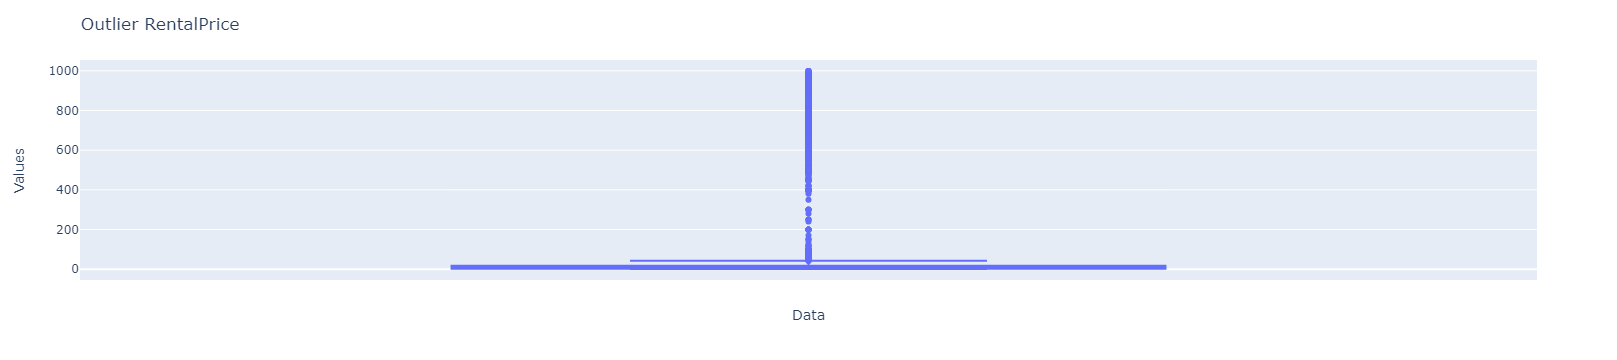

In [468]:
fig = px.box(
    df["listing.pricingInfo.rentalPrice"], y=df["listing.pricingInfo.rentalPrice"]
)
fig.update_layout(
    title="Outlier RentalPrice",
    xaxis=dict(title="Data"),
    yaxis=dict(title="Values"),
    boxmode="group",
    showlegend=False,
)
fig.show()

In [469]:
num_columns = [
    "listing.pricingInfo.rentalPrice",
    "listing.pricingInfo.yearlyIptu",
    "listing.usableAreas",
    "listing.totalAreas",
    "listing.pricingInfo.monthlyCondoFee",
    # "listing.unitFloor",
    # "listing.unitsOnTheFloor",
    # "listing.floors",
    # "listing.parkingSpaces",
]

df = remove_outliers(df, num_columns)

In [470]:
len(df["listing.pricingInfo.rentalPrice"].unique())

831

In [471]:
len(df["listing.pricingInfo.monthlyCondoFee"].unique())

929

In [472]:
df[["listing.pricingInfo.monthlyCondoFee"]].sort_values(
    "listing.pricingInfo.monthlyCondoFee"
)

,listing.pricingInfo.monthlyCondoFee
15656,136.0
15409,136.0
15186,137.0
14768,138.0
15337,138.0
...,...
57606,1419.0
13299,1420.0
52249,1421.0
51533,1421.0


#### Save

In [473]:
df.to_csv("./dataZap_final.csv", sep=";", index=False)

#### Selecionar as features baseada na correlação

In [474]:
df = pd.read_csv("dataZap_final.csv", delimiter=";")
df.shape

(8175, 32)

In [475]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8175 entries, 0 to 8174
Data columns (total 32 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   listing.garden                       8175 non-null   bool   
 1   listing.suites                       8175 non-null   float64
 2   listing.bathtub                      8175 non-null   bool   
 3   listing.pricingInfo.yearlyIptu       8175 non-null   float64
 4   listing.pricingInfo.monthlyCondoFee  8175 non-null   float64
 5   listing.address.neighborhood         8175 non-null   object 
 6   listing.totalAreas                   8175 non-null   float64
 7   listing.pricingInfo.rentalPrice      8175 non-null   float64
 8   listing.hottub                       8175 non-null   bool   
 9   listing.sportcourt                   8175 non-null   bool   
 10  listing.soundproofing                8175 non-null   bool   
 11  listing.furnished             

In [476]:
df["listing.pricingInfo.yearlyIptu"] = df["listing.pricingInfo.yearlyIptu"].astype(
    float
)
df["listing.pricingInfo.monthlyCondoFee"] = df[
    "listing.pricingInfo.monthlyCondoFee"
].astype(float)
df["listing.usableAreas"] = df["listing.usableAreas"].astype(float)
df["listing.floors"] = df["listing.floors"].astype(float)
df["listing.parkingSpaces"] = df["listing.parkingSpaces"].astype(float)
df["listing.unitsOnTheFloor"] = df["listing.unitsOnTheFloor"].astype(float)
df["listing.unitFloor"] = df["listing.unitFloor"].astype(float)

df["listing.bedrooms"] = df["listing.bedrooms"].astype("category")
df["listing.bathrooms"] = df["listing.bathrooms"].astype("category")
df["listing.suites"] = df["listing.suites"].astype("category")
df["listing.address.neighborhood"] = df["listing.address.neighborhood"].astype(
    "category"
)
df["listing.address.zone"] = df["listing.address.zone"].astype("category")
df["imvl_type"] = df["imvl_type"].astype("category")

In [477]:
df.isna().sum()

listing.garden                         0
listing.suites                         0
listing.bathtub                        0
listing.pricingInfo.yearlyIptu         0
listing.pricingInfo.monthlyCondoFee    0
listing.address.neighborhood           0
listing.totalAreas                     0
listing.pricingInfo.rentalPrice        0
listing.hottub                         0
listing.sportcourt                     0
listing.soundproofing                  0
listing.furnished                      0
listing.unitsOnTheFloor                0
listing.unitFloor                      0
listing.bedrooms                       0
listing.address.zone                   0
listing.parkingSpaces                  0
listing.bathrooms                      0
listing.tenniscourt                    0
listing.pool                           0
listing.partyhall                      0
listing.guestpark                      0
listing.barbgrill                      0
listing.playground                     0
listing.usableAr

<Axes: >

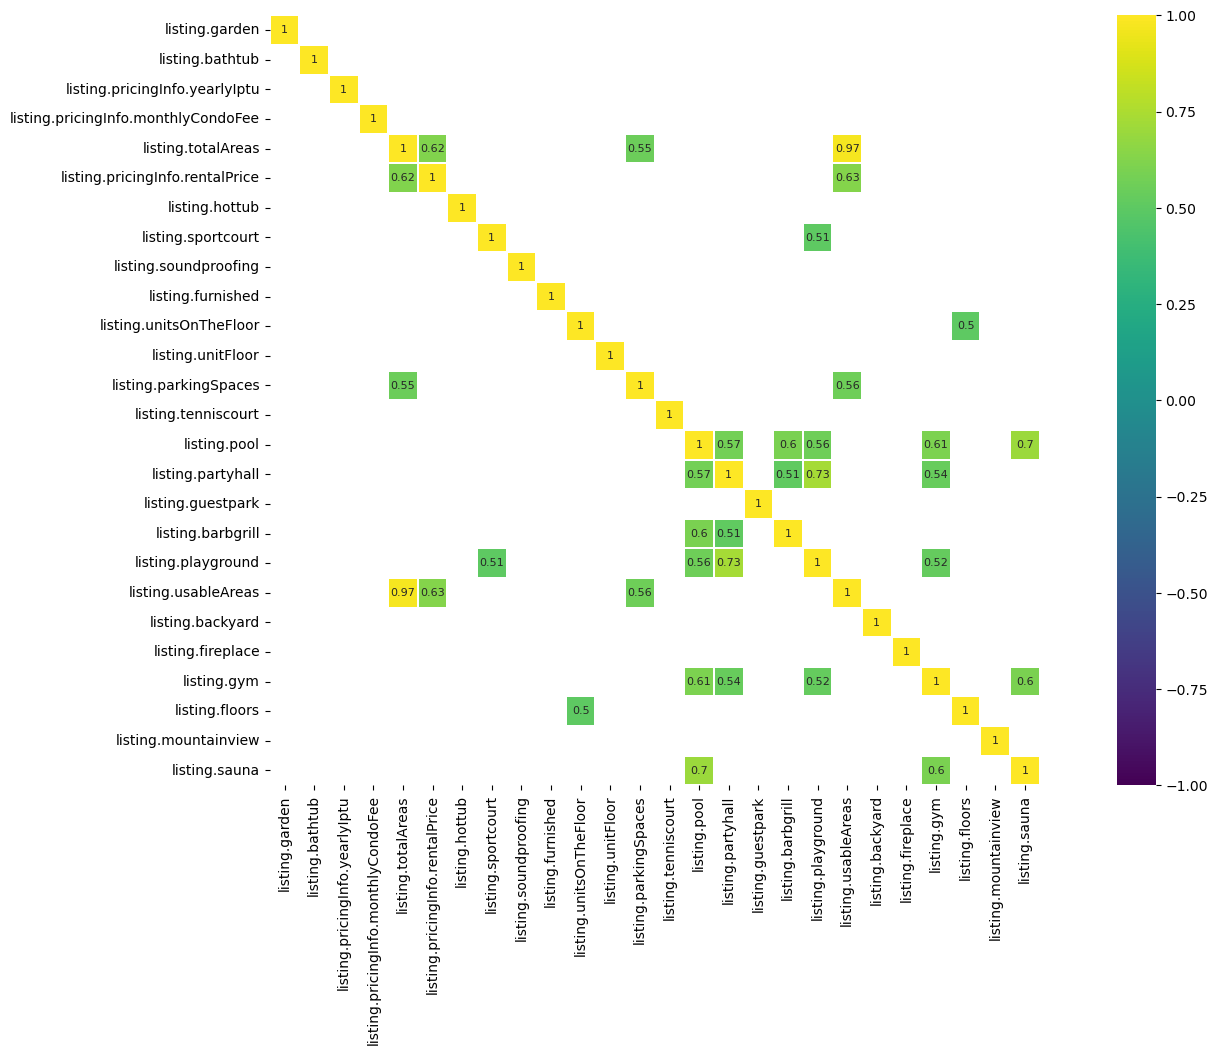

In [478]:
plt.subplots(figsize=(20, 10))
# sns.heatmap(df.corr(), cmap="RdBu", cbar=True, annot=True)
corr = df.corr()
sns.heatmap(
    corr[(corr >= 0.5) | (corr <= -0.4)],
    cmap="viridis",
    vmax=1.0,
    vmin=-1.0,
    linewidths=0.1,
    annot=True,
    annot_kws={"size": 8},
    square=True,
)

Valores com uma correlação considerável:

- listing_sauna x listing pool
- listing.playground x listing.sportcourt
- listing.pricinginfo.rentalPrice x listing.bedrooms
- listing.bathtub x listing.hottub
- listing.partyhall x listing.playground
- listing.pool x listing.barbgrill

Apesar de alguns terem valores de correlação alto, não considero retirar algumas colunas pois elas podem existir mesmo que a outra não exista, então é importante deixar pois são características diferentes.

#### Categorico para numérico

In [479]:
df.shape

(8175, 32)

In [480]:
bool_columns = [
    "listing.mountainview",
    "listing.sauna",
    "listing.sportcourt",
    "listing.hottub",
    "listing.fireplace",
    "listing.guestpark",
    "listing.soundproofing",
    "listing.gym",
    "listing.playground",
    "listing.partyhall",
    "listing.backyard",
    "listing.garden",
    "listing.barbgrill",
    "listing.furnished",
    "listing.tenniscourt",
    "listing.bathtub",
    "listing.pool",
]


cat_columns = [
    # "listing.address.neighborhood",
    "listing.address.zone",
    "imvl_type",
]

ordinal_cat_columns = [
    "listing.suites",
    "listing.bedrooms",
    "listing.bathrooms",
]

num_columns = [
    # "listing.pricingInfo.rentalPrice",
    "listing.pricingInfo.yearlyIptu",
    "listing.usableAreas",
    "listing.totalAreas",
    "listing.pricingInfo.monthlyCondoFee",
    "listing.unitFloor",
    "listing.unitsOnTheFloor",
    "listing.floors",
    "listing.parkingSpaces",
]

print(len(bool_columns))
print(len(cat_columns))
print(len(ordinal_cat_columns))
print(len(num_columns))

17
2
3
8


In [481]:
df["listing.bathrooms"].value_counts()

1     3393
2     2391
3     1350
4      605
5      259
6       93
0       39
7       23
8       10
9        5
11       4
10       2
12       1
Name: listing.bathrooms, dtype: int64

In [482]:
df[cat_columns]

,listing.address.zone,imvl_type
0,Zona Sul,apartamentos
1,Zona Sul,apartamentos
2,Zona Sul,apartamentos
3,Zona Sul,apartamentos
4,Zona Sul,apartamentos
...,...,...
8170,Zona Norte,casas-de-condominio
8171,Zona Norte,apartamentos
8172,Zona Sul,apartamentos
8173,Zona Oeste,apartamentos


In [483]:
df["listing.address.zone"].value_counts()

Zona Oeste            2706
Zona Sul              2628
Zona Norte            2326
Zona Central           220
Ilha do Governador     142
Bairros                102
normal                  51
Name: listing.address.zone, dtype: int64

In [484]:
df["imvl_type"].value_counts()

apartamentos           5740
casas                  1041
cobertura               892
quitinetes              286
casas-de-condominio      95
flat                     69
casas-de-vila            49
studio                    3
Name: imvl_type, dtype: int64

In [485]:
df["listing.address.neighborhood"].value_counts()

Copacabana                  834
Recreio Dos Bandeirantes    666
Barra da Tijuca             476
Ipanema                     460
Leblon                      378
                           ... 
Cidade De Deus                1
Manguinhos                    1
Barra De Guaratiba            1
Saúde                         1
Arpoador                      1
Name: listing.address.neighborhood, Length: 147, dtype: int64

In [486]:
# Categorical to numerical - cat_columns
freq = df["listing.address.neighborhood"].value_counts(normalize=True)
df["listing.address.neighborhood"] = df["listing.address.neighborhood"].map(freq)

In [487]:
df = encode_categorical_columns(df, cat_columns)
df

,listing.garden,listing.suites,listing.bathtub,listing.pricingInfo.yearlyIptu,listing.pricingInfo.monthlyCondoFee,listing.address.neighborhood,listing.totalAreas,listing.pricingInfo.rentalPrice,listing.hottub,listing.sportcourt,listing.soundproofing,listing.furnished,listing.unitsOnTheFloor,listing.unitFloor,listing.bedrooms,listing.parkingSpaces,listing.bathrooms,listing.tenniscourt,listing.pool,listing.partyhall,listing.guestpark,listing.barbgrill,listing.playground,listing.usableAreas,listing.backyard,listing.fireplace,listing.gym,listing.floors,listing.mountainview,listing.sauna,listing.address.zone_Bairros,listing.address.zone_Ilha do Governador,listing.address.zone_Zona Central,listing.address.zone_Zona Norte,listing.address.zone_Zona Oeste,listing.address.zone_Zona Sul,listing.address.zone_normal,imvl_type_apartamentos,imvl_type_casas,imvl_type_casas-de-condominio,imvl_type_casas-de-vila,imvl_type_cobertura,imvl_type_flat,imvl_type_quitinetes,imvl_type_studio
0,False,1.0,False,142.000,550.0,0.005749,50.0,2.65,False,False,False,True,0.0,5.0,1,0.0,2,False,False,False,False,False,False,50.0,False,False,False,12.0,False,False,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
1,False,0.0,False,109.000,850.0,0.102018,50.0,2.30,False,False,False,True,0.0,0.0,1,0.0,1,False,False,False,False,False,False,50.0,False,False,False,1.0,False,False,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
2,False,0.0,False,230.000,993.0,0.056269,52.0,4.70,False,False,False,False,0.0,0.0,1,0.0,1,False,False,False,False,False,False,52.0,False,False,False,1.0,False,False,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
3,False,0.0,False,143.000,1027.0,0.030214,56.0,2.70,False,False,False,False,0.0,11.0,1,1.0,1,False,False,False,False,False,False,56.0,False,False,False,1.0,False,False,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
4,False,0.0,False,140.000,1086.0,0.102018,47.0,1.70,False,False,False,False,0.0,5.0,1,1.0,1,False,False,False,False,False,False,47.0,False,False,False,1.0,False,False,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8170,False,2.0,False,1.615,660.0,0.038410,126.0,2.50,False,False,False,False,0.0,0.0,2,2.0,3,False,False,False,False,False,False,100.0,False,False,True,1.0,False,False,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
8171,False,1.0,False,96.000,740.0,0.038410,88.0,1.90,False,False,False,False,8.0,0.0,3,1.0,3,False,False,False,False,False,False,75.0,False,False,False,8.0,False,False,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
8172,False,0.0,False,91.000,690.0,0.102018,45.0,1.59,False,False,False,True,0.0,0.0,1,0.0,1,False,False,False,False,False,False,45.0,False,False,False,1.0,False,False,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
8173,False,1.0,False,257.000,500.0,0.081468,96.0,1.80,False,False,False,False,0.0,0.0,3,1.0,3,False,False,False,False,False,False,96.0,False,False,False,1.0,False,False,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0


In [488]:
df[bool_columns]

,listing.mountainview,listing.sauna,listing.sportcourt,listing.hottub,listing.fireplace,listing.guestpark,listing.soundproofing,listing.gym,listing.playground,listing.partyhall,listing.backyard,listing.garden,listing.barbgrill,listing.furnished,listing.tenniscourt,listing.bathtub,listing.pool
0,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8170,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
8171,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
8172,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
8173,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [489]:
df[bool_columns] = df[bool_columns].astype(int)
df[bool_columns]

,listing.mountainview,listing.sauna,listing.sportcourt,listing.hottub,listing.fireplace,listing.guestpark,listing.soundproofing,listing.gym,listing.playground,listing.partyhall,listing.backyard,listing.garden,listing.barbgrill,listing.furnished,listing.tenniscourt,listing.bathtub,listing.pool
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8170,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
8171,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8172,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
8173,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


##### Explicar que o categorical columns aumenta muito a dimensionalidade e o desempenho do modelo e por isso foi utilizado outros métodos para transformar os dados categóricos em numericos

In [490]:
le = LabelEncoder()

for categorical in ordinal_cat_columns:
    df[categorical] = df[categorical].astype(str)
    df[categorical] = le.fit_transform(df[categorical])

#### Normalização dos Dados

In [491]:
df.head(2)

,listing.garden,listing.suites,listing.bathtub,listing.pricingInfo.yearlyIptu,listing.pricingInfo.monthlyCondoFee,listing.address.neighborhood,listing.totalAreas,listing.pricingInfo.rentalPrice,listing.hottub,listing.sportcourt,listing.soundproofing,listing.furnished,listing.unitsOnTheFloor,listing.unitFloor,listing.bedrooms,listing.parkingSpaces,listing.bathrooms,listing.tenniscourt,listing.pool,listing.partyhall,listing.guestpark,listing.barbgrill,listing.playground,listing.usableAreas,listing.backyard,listing.fireplace,listing.gym,listing.floors,listing.mountainview,listing.sauna,listing.address.zone_Bairros,listing.address.zone_Ilha do Governador,listing.address.zone_Zona Central,listing.address.zone_Zona Norte,listing.address.zone_Zona Oeste,listing.address.zone_Zona Sul,listing.address.zone_normal,imvl_type_apartamentos,imvl_type_casas,imvl_type_casas-de-condominio,imvl_type_casas-de-vila,imvl_type_cobertura,imvl_type_flat,imvl_type_quitinetes,imvl_type_studio
0,0,1,0,142.0,550.0,0.005749,50.0,2.65,0,0,0,1,0.0,5.0,1,0.0,5,0,0,0,0,0,0,50.0,0,0,0,12.0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
1,0,0,0,109.0,850.0,0.102018,50.0,2.30,0,0,0,1,0.0,0.0,1,0.0,1,0,0,0,0,0,0,50.0,0,0,0,1.0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0


In [492]:
df = standardize_columns(df, num_columns)
df.head(2)

,listing.garden,listing.suites,listing.bathtub,listing.pricingInfo.yearlyIptu,listing.pricingInfo.monthlyCondoFee,listing.address.neighborhood,listing.totalAreas,listing.pricingInfo.rentalPrice,listing.hottub,listing.sportcourt,listing.soundproofing,listing.furnished,listing.unitsOnTheFloor,listing.unitFloor,listing.bedrooms,listing.parkingSpaces,listing.bathrooms,listing.tenniscourt,listing.pool,listing.partyhall,listing.guestpark,listing.barbgrill,listing.playground,listing.usableAreas,listing.backyard,listing.fireplace,listing.gym,listing.floors,listing.mountainview,listing.sauna,listing.address.zone_Bairros,listing.address.zone_Ilha do Governador,listing.address.zone_Zona Central,listing.address.zone_Zona Norte,listing.address.zone_Zona Oeste,listing.address.zone_Zona Sul,listing.address.zone_normal,imvl_type_apartamentos,imvl_type_casas,imvl_type_casas-de-condominio,imvl_type_casas-de-vila,imvl_type_cobertura,imvl_type_flat,imvl_type_quitinetes,imvl_type_studio
0,0,1,0,0.012966,-0.586977,0.005749,-0.87489,2.65,0,0,0,1,-0.316721,1.189570,1,-1.055722,5,0,0,0,0,0,0,-0.861063,0,0,0,2.055671,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
1,0,0,0,-0.171124,0.677862,0.102018,-0.87489,2.30,0,0,0,1,-0.316721,-0.417612,1,-1.055722,1,0,0,0,0,0,0,-0.861063,0,0,0,-0.395418,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0


#### Save 2

In [493]:
df.to_csv("./dataZap_normalized.csv", sep=";", index=False)

### Divisão Treino e Teste

In [494]:
df = pd.read_csv("dataZap_normalized.csv", delimiter=";")
df.shape

(8175, 45)

In [495]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8175 entries, 0 to 8174
Data columns (total 45 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   listing.garden                           8175 non-null   int64  
 1   listing.suites                           8175 non-null   int64  
 2   listing.bathtub                          8175 non-null   int64  
 3   listing.pricingInfo.yearlyIptu           8175 non-null   float64
 4   listing.pricingInfo.monthlyCondoFee      8175 non-null   float64
 5   listing.address.neighborhood             8175 non-null   float64
 6   listing.totalAreas                       8175 non-null   float64
 7   listing.pricingInfo.rentalPrice          8175 non-null   float64
 8   listing.hottub                           8175 non-null   int64  
 9   listing.sportcourt                       8175 non-null   int64  
 10  listing.soundproofing                    8175 no

In [496]:
X = df.drop(["listing.pricingInfo.rentalPrice"], axis=1)
y = df["listing.pricingInfo.rentalPrice"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Regressões

#### Regressão Linear

With pd.dummies categorizer / onehotencoder

In [497]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred = linear_model.predict(X_test)

In [498]:
evaluate_metrics(y_test, y_pred)

Model testing performance:
--------------------------
R2_score 	: 0.6291
MAE 		: 2.3174
MSE 		: 12.7755
RMSE 		: 3.5743


In [499]:
y_test = np.array(list(y_test))
y_pred = np.array(y_pred)
df_final = pd.DataFrame({"Actual": y_test.flatten(), "Predicted": y_pred.flatten()})
df_final

,Actual,Predicted
0,3.00,5.694756
1,1.90,4.659967
2,3.00,2.317899
3,3.00,8.055542
4,28.40,20.754522
...,...,...
1630,1.20,1.983531
1631,1.00,1.630331
1632,5.35,4.362559
1633,1.00,-2.129940


#### Regressão Ridge

In [500]:
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
y_pred = ridge_model.predict(X_test)

In [501]:
evaluate_metrics(y_test, y_pred)

Model testing performance:
--------------------------
R2_score 	: 0.6297
MAE 		: 2.315
MSE 		: 12.7554
RMSE 		: 3.5715


#### Regressão Lasso

In [502]:
lasso_model = Lasso(alpha=1.0)
lasso_model.fit(X_train, y_train)
y_pred = lasso_model.predict(X_test)

In [503]:
evaluate_metrics(y_test, y_pred)

Model testing performance:
--------------------------
R2_score 	: 0.375
MAE 		: 2.7501
MSE 		: 21.5296
RMSE 		: 4.64


#### Regressão ElasticNet

In [504]:
elasticnet_model = ElasticNet(alpha=1.0)
elasticnet_model.fit(X_train, y_train)
y_pred = elasticnet_model.predict(X_test)

In [505]:
evaluate_metrics(y_test, y_pred)

Model testing performance:
--------------------------
R2_score 	: 0.4118
MAE 		: 2.6466
MSE 		: 20.2609
RMSE 		: 4.5012


#### Regressão Logística

Não é possível fazer regressão logística com esse dataset

#### Regressão com KNN

In [506]:
knn_model = KNeighborsRegressor()
knn_model.fit(X_train, y_train)

KNeighborsRegressor()

In [507]:
y_pred = knn_model.predict(X_test)
evaluate_metrics(y_test, y_pred)

Model testing performance:
--------------------------
R2_score 	: 0.7379
MAE 		: 1.5697
MSE 		: 9.0292
RMSE 		: 3.0049


#### Regressão com Árvore

In [508]:
decision_tree_model = DecisionTreeRegressor()
decision_tree_model.fit(X_train, y_train)

DecisionTreeRegressor()

In [509]:
y_pred = decision_tree_model.predict(X_test)
evaluate_metrics(y_test, y_pred)

Model testing performance:
--------------------------
R2_score 	: 0.7225
MAE 		: 1.4916
MSE 		: 9.5594
RMSE 		: 3.0918


#### Resultado Final das Regressões

In [510]:
linear_metrics = evaluate_metrics_cv(linear_model, X_train, y_train, X_test, y_test)
# logistic_metrics = evaluate_metrics_cv(logistic_model, X_train, y_train, X_test, y_test)
knn_metrics = evaluate_metrics_cv(knn_model, X_train, y_train, X_test, y_test)
decision_tree_metrics = evaluate_metrics_cv(
    decision_tree_model, X_train, y_train, X_test, y_test
)
ridge_metrics = evaluate_metrics_cv(ridge_model, X_train, y_train, X_test, y_test)
lasso_metrics = evaluate_metrics_cv(lasso_model, X_train, y_train, X_test, y_test)
elasticnet_metrics = evaluate_metrics_cv(
    elasticnet_model, X_train, y_train, X_test, y_test
)

In [511]:
data = {"Model": [], "Metric": [], "without CV": [], "CV": []}

for model_metrics in [
    linear_metrics,
    ridge_metrics,
    lasso_metrics,
    elasticnet_metrics,
    knn_metrics,
    decision_tree_metrics,
]:
    model_name, *metrics = model_metrics
    for metric_name, value in zip(
        [
            "R2 Score",
            "Cross-Validated R2 Score",
            "Root Mean Squared Error",
            "Cross-Validated Root Mean Squared Error",
            "Mean Absolute Error",
            "Cross-Validated Mean Absolute Error",
        ],
        metrics,
    ):
        data["Model"].append(model_name)
        data["Metric"].append(metric_name)
        data["without CV"].append(
            value
            if metric_name != "Cross-Validated R2 Score"
            and metric_name != "Cross-Validated Root Mean Squared Error"
            and metric_name != "Cross-Validated Mean Absolute Error"
            else ""
        )
        data["CV"].append(
            value
            if metric_name == "Cross-Validated R2 Score"
            or metric_name == "Cross-Validated Root Mean Squared Error"
            or metric_name == "Cross-Validated Mean Absolute Error"
            else "-"
        )

df_evaluation = pd.DataFrame(data)
df_evaluation

,Model,Metric,without CV,CV
0,Linear Regression,R2 Score,0.629133,-
1,Linear Regression,Cross-Validated R2 Score,,0.64481
2,Linear Regression,Root Mean Squared Error,3.574276,-
3,Linear Regression,Cross-Validated Root Mean Squared Error,,3.443869
4,Linear Regression,Mean Absolute Error,2.317401,-
5,Linear Regression,Cross-Validated Mean Absolute Error,,2.246484
6,Ridge,R2 Score,0.629714,-
7,Ridge,Cross-Validated R2 Score,,0.644847
8,Ridge,Root Mean Squared Error,3.571475,-
9,Ridge,Cross-Validated Root Mean Squared Error,,3.443702
